In [36]:
%matplotlib inline
import numpy as np
import pysal as ps
import random as rdm
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import json
import geojson as gj
#from pysal.contrib.viz import folium_mapping as fm
import folium as fl
from pysal.contrib.viz import folium_mapping as fm
from pylab import rcParams
rcParams['figure.figsize'] = 20,20

First, plot Denver Census tract geography without attributes

[]

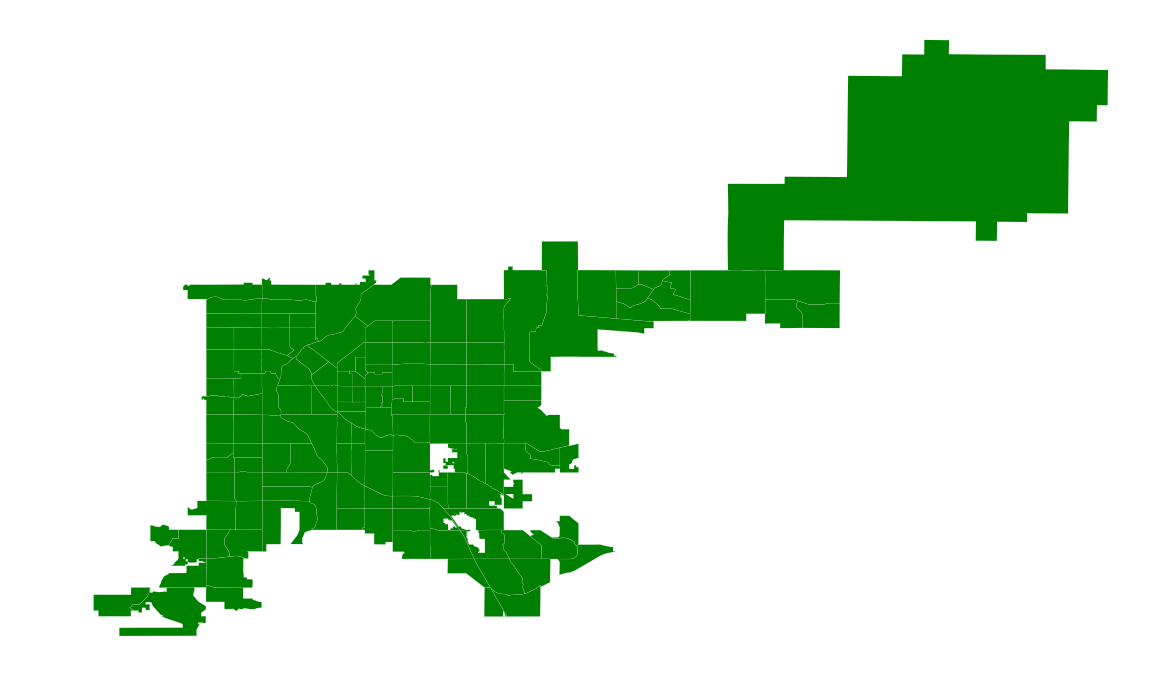

In [51]:
den = gpd.read_file('ACS/ACS.shp')

data_table = ps.pdio.read_files('ACS/ACS.shp')





den['constant'] = 1
p = den.plot(color='green', linewidth=0.1, edgecolor='white')
p.axis('off')
p.plot()

#Choropleths of Median Household Income

Quantiles

[]

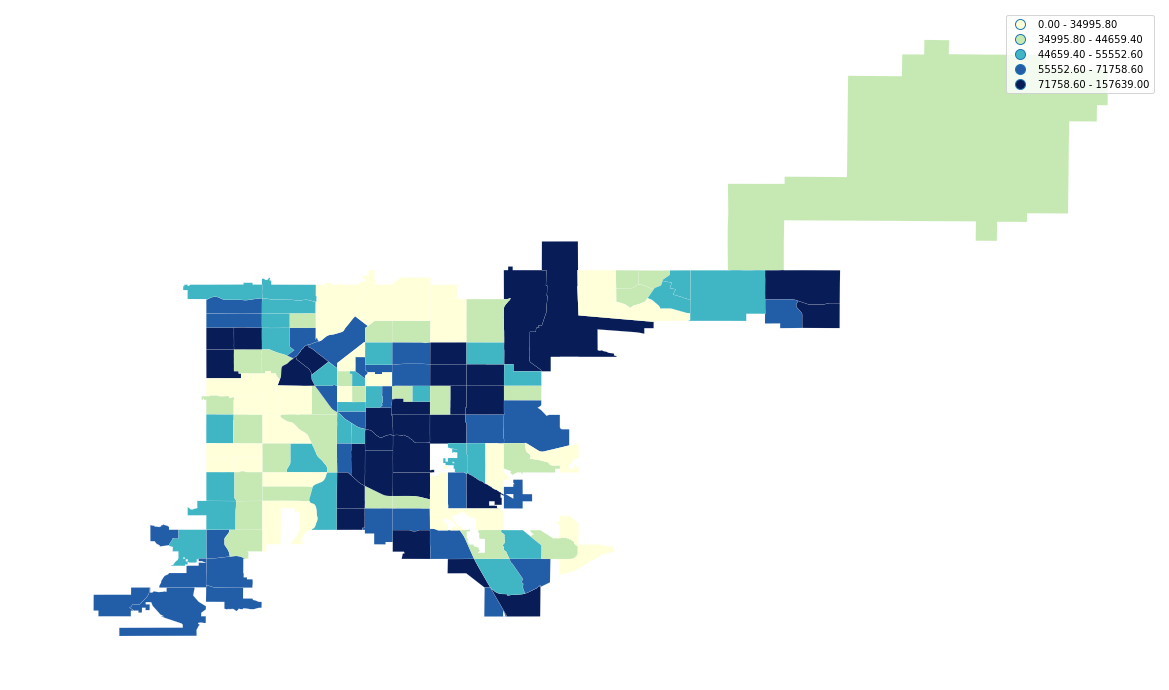

In [68]:
quant = den.plot(column='MED_HH_INC', scheme='QUANTILES', k=5, cmap='YlGnBu', linewidth=0.1, edgecolor='white',legend=True)
quant.axis('off')
quant.plot()

[]

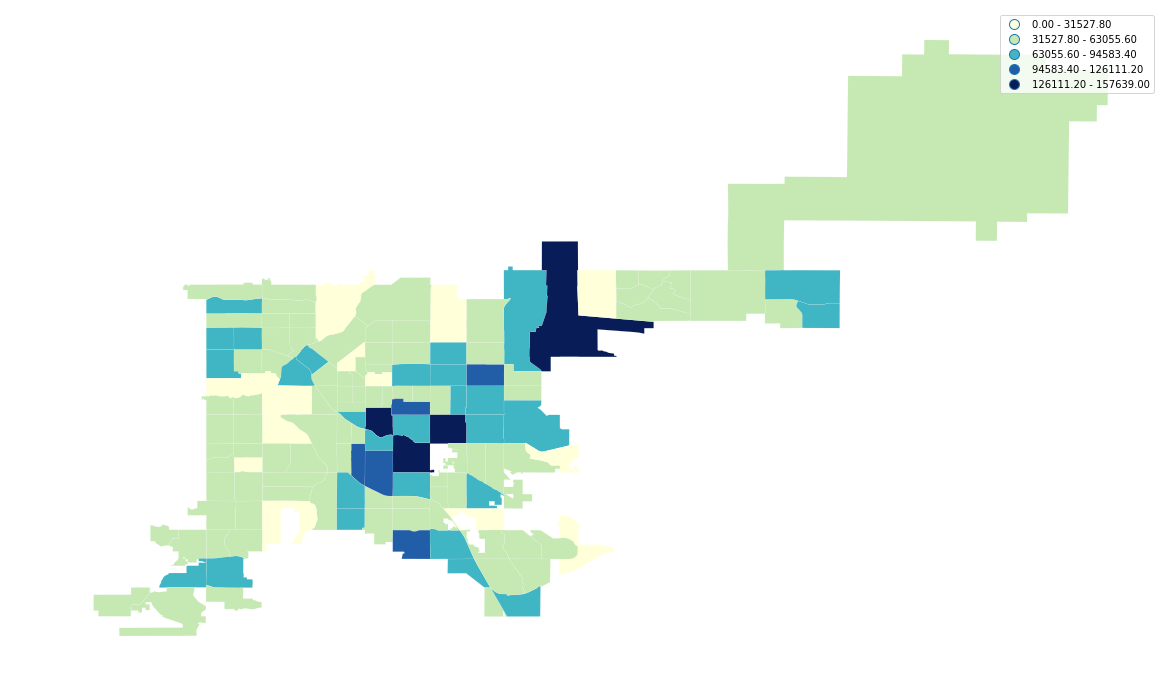

In [69]:
#Equal Interval Plot

eqint = den.plot(column='MED_HH_INC', scheme='equal_interval', k=5, cmap='YlGnBu', linewidth=0.1, edgecolor='white', legend=True)
eqint.axis('off')
eqint.plot()

[]

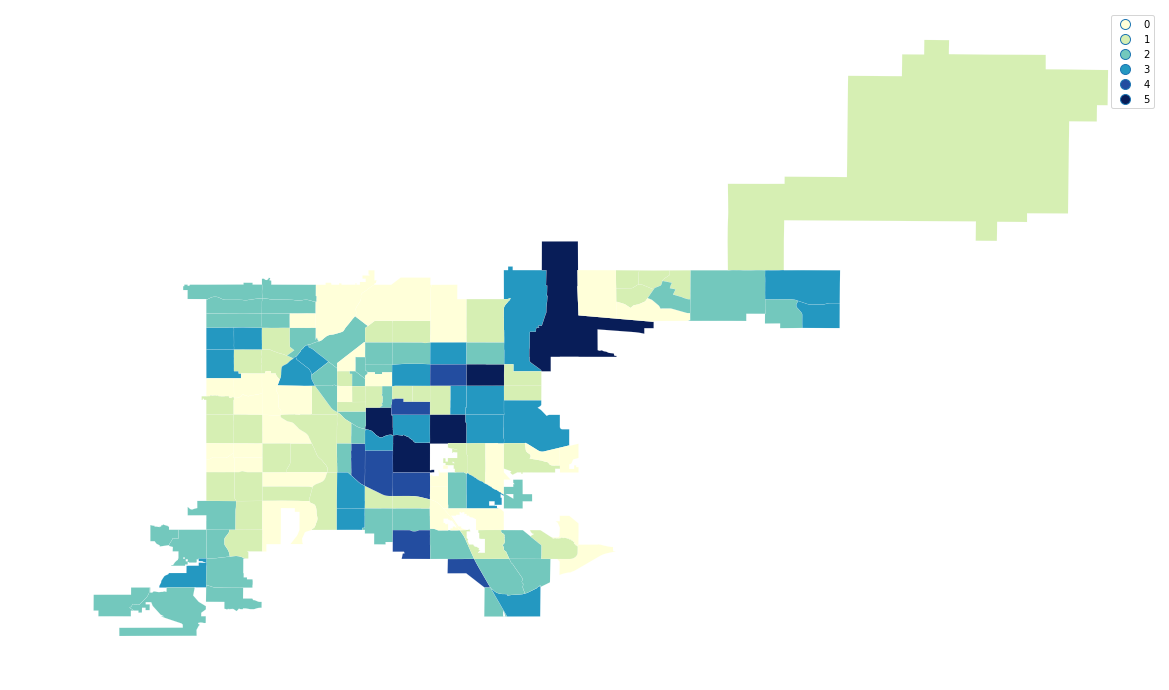

In [67]:
# Fisher-Jenks Classification

jenks6 = ps.Fisher_Jenks(den.MED_HH_INC, k=6)
jenks6.bins
den['JENKS_CAT'] = jenks6.yb
jenks = den.plot(column='JENKS_CAT', categorical=True, k=6, cmap='YlGnBu', linewidth=0.1,\
        edgecolor='white', legend=True)
jenks.axis('off')
jenks.plot()


In [37]:
filepath = 'ACS/ACS.shp'[:-4]
shp = ps.open(filepath + '.shp')
dbf = ps.open(filepath + '.dbf')

js = fm.build_features(shp, dbf)



In [40]:
with open('./denACS.json', 'w') as out:
    gj.dump(js, out)

In [ ]:
from branca.utilities import split_six

threshold_scale = split_six(data_table['MED_HH_INC'])

denFM = fl.Map(location=[39.73, -104.99], \
               zoom_start=10, tiles = 'cartodbpositron')

denFM.choropleth(
    geo_data=gpd.read_file('./denACS.json'),
    name='choropleth',
    data= data_table,
    columns=['GEO_NAME','MED_HH_INC'],
    fill_color='YlGnBu',
    key_on='feature.properties.GEO_NAME',
    fill_opacity=0.5,
    line_opacity=0.1,
    legend_name='Median Household Income in $',
    threshold_scale=threshold_scale,
)


fl.LayerControl().add_to(denFM)

denFM

In [23]:
# Use pysal to determine tract neighbors
w = ps.rook_from_shapefile('ACS/ACS.shp', idVariable='STFID')
print w.n   # Total number of census tracts in Denver

144


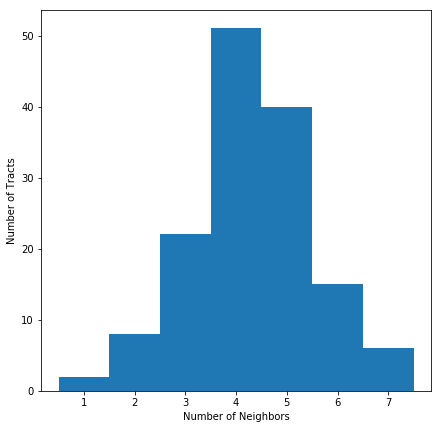

In [17]:
# Summary of the connectivity between census tracts
w_hist_data = np.array(w.histogram)
fig, ax = plt.subplots(figsize=(7,7))
ax.bar(w_hist_data[:,0], w_hist_data[:,1], align='center', width=1)
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Number of Tracts')

In [54]:
# Caluclate Global Moran's I for Household Income
y = np.array(shp_map['MED_HH_INC'])
mi = ps.Moran(y, w, two_tailed=False)
mi.I
lags = ps.lag_spatial(w,y)

In [40]:
# Caluclate and Map Local Moran's I
np.random.seed(12345)
lm = ps.Moran_Local(y,w)
lm.n # Check that there are the same number of local Moran's I statistics as there are tracts
shp_map['lm'] = np.array(lm.Is)

In [50]:
# Test significance of Local Moran's I values. Set alpha = 0.05
sig = lm.p_sim<=0.05
sig.sum() # There are 28 tracts with significant Local Moran's I values

28

In [ ]:
# Map of Local Moran's I for Denver Median Household Income

[]

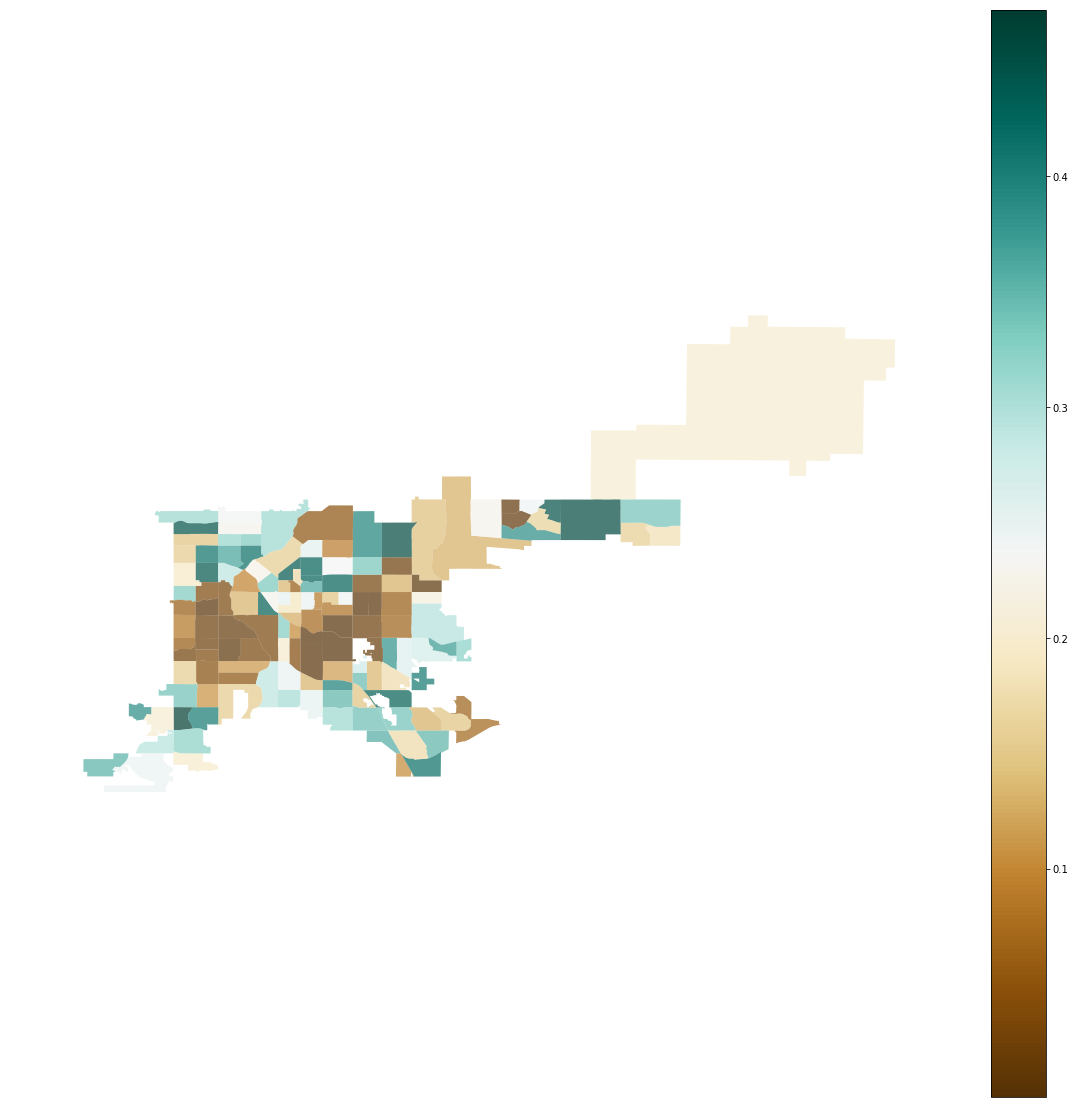

In [52]:
shp_map['lm_p'] = np.array(lm.p_sim)
lm_map = shp_map.plot('lm_p', alpha=0.7, cmap='BrBG', legend=True)
lm_map.axis('off')
lm_map.plot()